In [4]:
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime as dt

In [5]:
df = stock_historical_data(symbol="FPT", type="stock", start_date="2006-12-13", end_date=str(dt.date.today()))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    2879 non-null   object
 1   open    2879 non-null   int32 
 2   high    2879 non-null   int32 
 3   low     2879 non-null   int32 
 4   close   2879 non-null   int32 
 5   volume  2879 non-null   int64 
 6   ticker  2879 non-null   object
dtypes: int32(4), int64(1), object(2)
memory usage: 112.6+ KB


In [6]:
df = df.sort_values('time', ascending=True)
df.head()

,time,open,high,low,close,volume,ticker
0,2012-03-20,6950,6950,6900,6900,94310,FPT
1,2012-03-21,6900,6950,6840,6900,145260,FPT
2,2012-03-22,6900,6900,6780,6780,90050,FPT
3,2012-03-23,6840,6840,6780,6840,71320,FPT
4,2012-03-26,6840,6840,6780,6840,112360,FPT


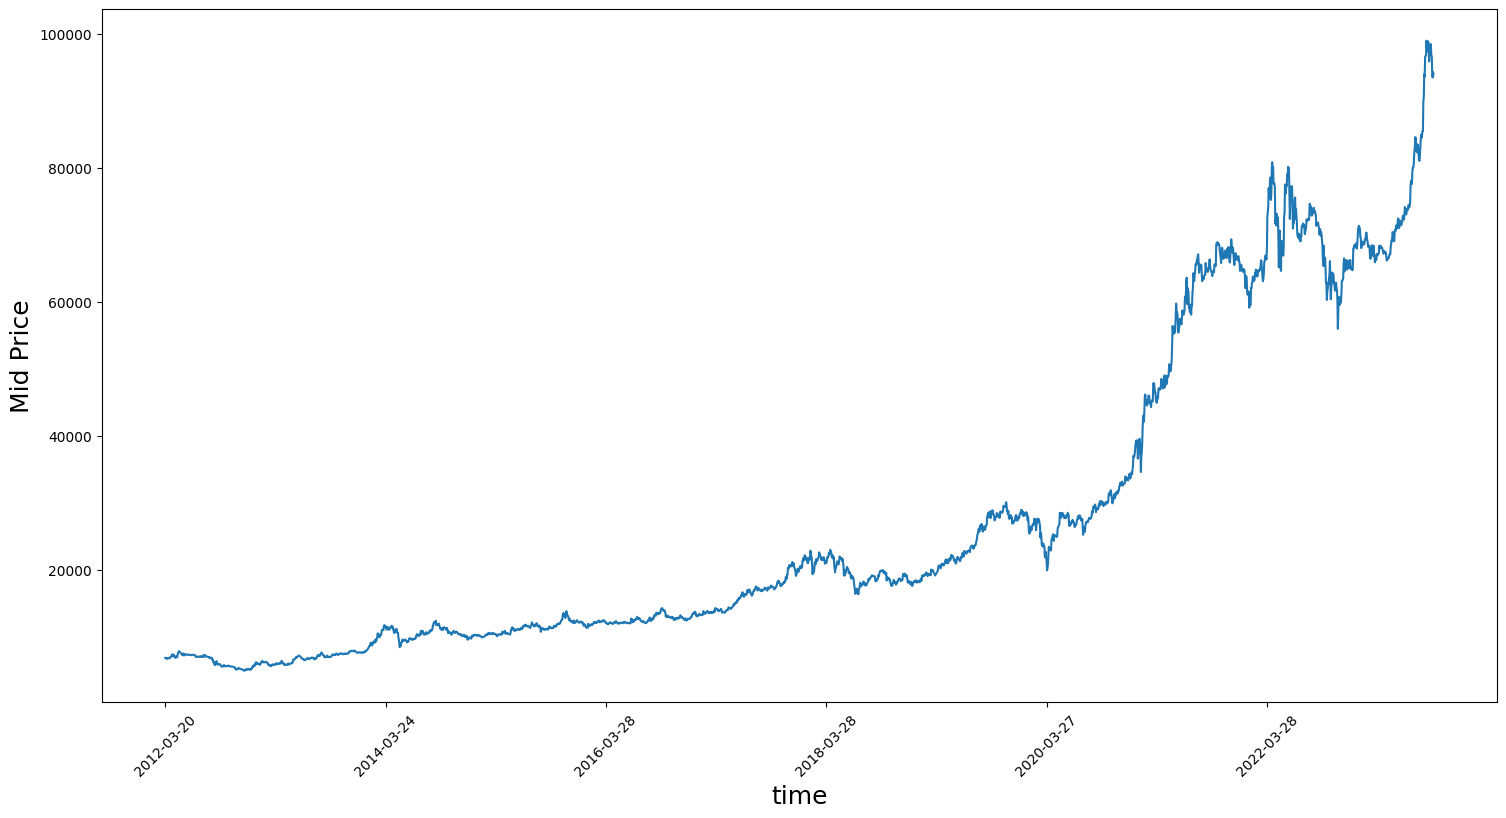

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['close']))
plt.xticks(range(0,df.shape[0],500),df['time'].loc[::500],rotation=45)
plt.xlabel('time',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [8]:
# Select the 'Close' prices for prediction
data = df[['close']]
data.head()

,close
0,6900
1,6900
2,6780
3,6840
4,6840


In [9]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(data[['close']])

C:\Users\PC\AppData\Local\Temp\ipykernel_3104\2121707581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close'] = scaler.fit_transform(data[['close']])


In [10]:
# Split the data into training and test sets
train_size = int(len(data) * 0.75)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

In [11]:
# Create sequences for the RNN
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length:i+sequence_length+1]
        sequences.append((sequence, target))
    return sequences

In [12]:
sequence_length = 60  # Length of input sequences
train_sequences = create_sequences(train_data.values, sequence_length)
test_sequences = create_sequences(test_data.values, sequence_length)

In [13]:
# Convert sequences to NumPy arrays
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

In [14]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss=keras.losses.Huber(), metrics=["mae"])

In [15]:
# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32)

Epoch 1/1000
66/66 [==============================] - 3s 11ms/step - loss: 0.0013 - mae: 0.0254
Epoch 2/1000
66/66 [==============================] - 1s 9ms/step - loss: 9.4064e-06 - mae: 0.0030
Epoch 3/1000
66/66 [==============================] - 1s 8ms/step - loss: 7.8719e-06 - mae: 0.0027
Epoch 4/1000
66/66 [==============================] - 1s 8ms/step - loss: 7.7899e-06 - mae: 0.0026
Epoch 5/1000
66/66 [==============================] - 1s 8ms/step - loss: 7.5075e-06 - mae: 0.0026
Epoch 6/1000
66/66 [==============================] - 1s 8ms/step - loss: 7.6678e-06 - mae: 0.0026
Epoch 7/1000
66/66 [==============================] - 1s 8ms/step - loss: 7.3570e-06 - mae: 0.0025
Epoch 8/1000
66/66 [==============================] - 1s 9ms/step - loss: 8.0997e-06 - mae: 0.0027
Epoch 9/1000
66/66 [==============================] - 1s 9ms/step - loss: 7.8395e-06 - mae: 0.0027
Epoch 10/1000
66/66 [==============================] - 1s 12ms/step - loss: 8.0980e-06 - mae: 0.0027
Epoch 11/10

In [16]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

# Reshape y_test and inverse transform
y_test = y_test.reshape(-1, y_test.shape[1])
y_test = scaler.inverse_transform(y_test)

21/21 [==============================] - 2s 10ms/step


In [17]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

21/21 [==============================] - 1s 12ms/step - loss: 66880.9844 - mae: 66881.4766
Loss: 66880.98
Mean Absolute Error (MAE): 66881.48


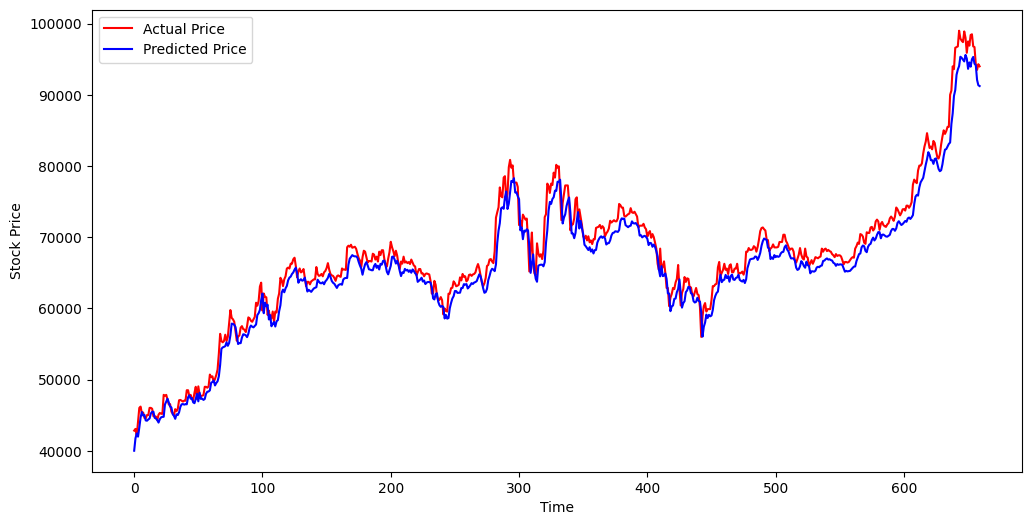

In [18]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='red')
plt.plot(y_pred, label='Predicted Price', color='blue')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [19]:
# Predict future stock prices
future_days = 30
future_predictions = []

last_sequence = X_test[-1]
for i in range(future_days):
    # Predict the next day's price
    next_day_prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_day_prediction[0][0])
    # Update the input sequence for the next prediction
    last_sequence = np.append(last_sequence[1:], next_day_prediction[0][0])  # Update the sequence with the predicted value

# Inverse transform the scaled future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 76ms/step


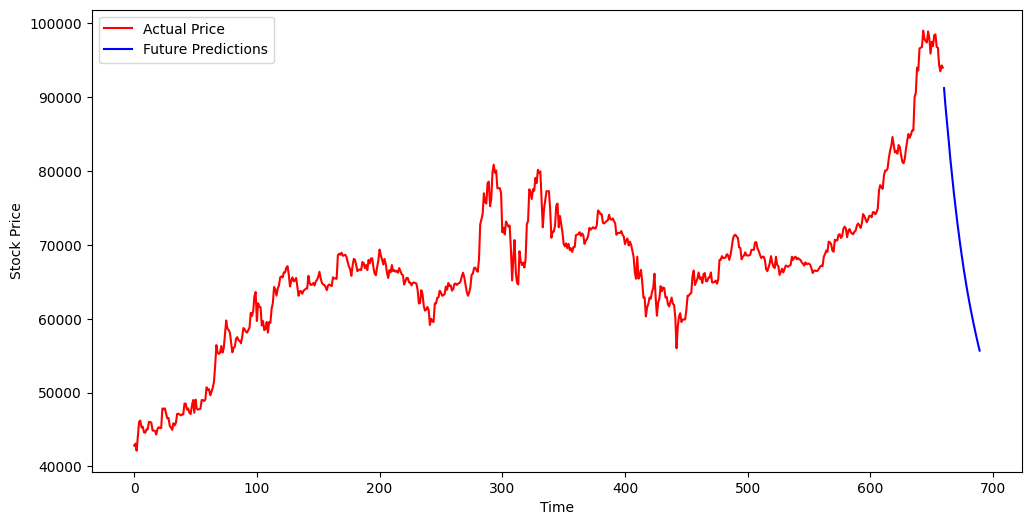

In [20]:
# Plot the predicted future stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='red')
plt.plot(range(len(y_test), len(y_test) + future_days), future_predictions, label='Future Predictions', color='blue')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()